# viz

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
from sklearn.decomposition import PCA

plt.matplotlib.style.use("https://gist.githubusercontent.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea/raw/64a78942d3f7b4b5054902f2cee84213eaff872f/matplotlibrc")
cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']
cool_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[5], 'RF (div)': cool_colors[3]}

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

load data

In [2]:
X = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['X']
print("shape of X:", np.shape(X))
y = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['y']
nb_data = np.size(y)
nb_data

shape of X: (69839, 12)


69839

for rankings

In [3]:
ids_to_rank = np.argsort(y.squeeze())
y_ranks = np.arange(nb_data)[np.flip(ids_to_rank).argsort()] + 1

In [4]:
y[y_ranks == 1] # ranked first

array([216.8941107])

In [5]:
y[y_ranks == nb_data] # ranked last

array([4.47994999])

load search results

In [6]:
bo_res     = pickle.load(open('bo_results.pkl', 'rb'))
rf_res     = pickle.load(open('rf_results.pkl', 'rb'))
rf_div_res = pickle.load(open('rf_div_results.pkl', 'rb'))
rs_res     = pickle.load(open('rs_results.pkl', 'rb'))
es_res     = pickle.load(open('es_results.pkl', 'rb'))

# PCA and viz of acquisition of BO

In [7]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

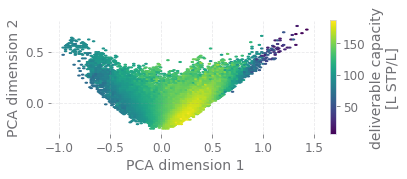

In [8]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
cb.set_label(label="deliverable capacity\n[L STP/L]")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')

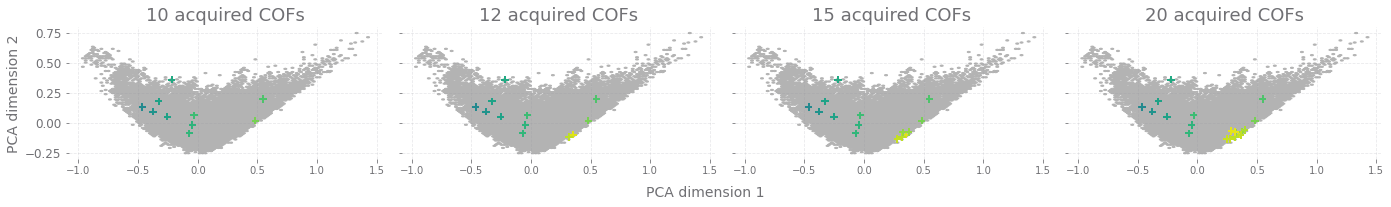

In [9]:
which_BO_run = 0

fig, ax = plt.subplots(1, 4, sharey=True, sharex=True, figsize=[3*6.4, 4.8])
nb_acquired = [10, 12, 15, 20]
# gray background
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_data), cmap="binary", vmin=0, vmax=1)
    
for i in range(4):
    ids_acquired = bo_res['ids_acquired'][which_BO_run][:nb_acquired[i]]
    assert len(ids_acquired) == nb_acquired[i]
    # use above colorbar to assign color!
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], 
                  c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x', labelsize=10)
ax[0].set_ylabel('PCA dimension 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.2, 'PCA dimension 1', ha='center', fontsize=14)
plt.tight_layout()
plt.savefig("feature_space_acquired_COFs.pdf")

# search efficiency
### max $y$ among acquired set.

In [10]:
# get y_max acquired up to iteration i for i = 1,2,...
def y_max(res, rank=False):
    y_max_mu      = np.zeros(res['nb_iterations'])
    y_max_sig_bot = np.zeros(res['nb_iterations'])
    y_max_sig_top = np.zeros(res['nb_iterations'])
    for i in range(1, res['nb_iterations']+1):
        # max value acquired up to this point
        if rank:
            y_maxes = np.array([np.min(y_ranks[res['ids_acquired'][r]][:i]) for r in range(res['nb_runs'])]) # among runs
        else:
            y_maxes = np.array([np.max(y[res['ids_acquired'][r]][:i]) for r in range(res['nb_runs'])]) # among runs
        assert np.size(y_maxes) == res['nb_runs']
        y_max_mu[i-1]      = np.mean(y_maxes)
        y_max_sig_bot[i-1] = np.std(y_maxes[y_maxes < y_max_mu[i-1]])
        y_max_sig_top[i-1] = np.std(y_maxes[y_maxes > y_max_mu[i-1]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top

y_max_mu_BO, y_max_sig_bot_BO, y_max_sig_top_BO = y_max(bo_res)
y_max_mu_es, y_max_sig_bot_es, y_max_sig_top_es = y_max(es_res)
y_max_mu_rs, y_max_sig_bot_rs, y_max_sig_top_rs = y_max(rs_res)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
def y_max_rf(rf_res, rank=False):
    # one for each # of evaluation budgets
    y_max_mu      = np.zeros(len(rf_res['nb_evals_budgets']))
    y_max_sig_bot = np.zeros(len(rf_res['nb_evals_budgets']))
    y_max_sig_top = np.zeros(len(rf_res['nb_evals_budgets']))
    for b in range(len(rf_res['nb_evals_budgets'])):
        # get y max over runs.
        if rank:
            y_maxes = np.array([np.min(y_ranks[rf_res['ids_acquired'][b][r]]) for r in range(rf_res['nb_runs'])])
        else:
            y_maxes = np.array([np.max(y[rf_res['ids_acquired'][b][r]]) for r in range(rf_res['nb_runs'])])
        assert np.size(y_maxes) == rf_res['nb_runs']
        y_max_mu[b]      = np.mean(y_maxes)
        y_max_sig_bot[b] = np.std(y_maxes[y_maxes < y_max_mu[b]])
        y_max_sig_top[b] = np.std(y_maxes[y_maxes > y_max_mu[b]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top    

In [12]:
y_max_mu_rf,     y_max_sig_bot_rf,     y_max_sig_top_rf     = y_max_rf(rf_res)
y_max_mu_rf_div, y_max_sig_bot_rf_div, y_max_sig_top_rf_div = y_max_rf(rf_div_res)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


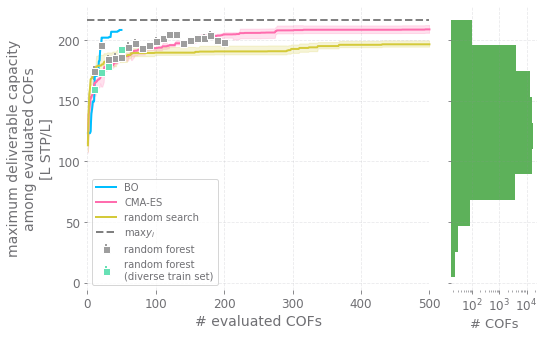

In [13]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[1.2 * 6.4, 4.8], sharey=True)
axs[0].plot(np.arange(bo_res['nb_iterations'])+1, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
axs[0].fill_between(np.arange(bo_res['nb_iterations'])+1, y_max_mu_BO - y_max_sig_bot_BO, 
                                                          y_max_mu_BO + y_max_sig_top_BO, 
                    alpha=0.2, ec="None", color=search_to_color['BO'])

# ES
axs[0].plot(np.arange(es_res['nb_iterations'])+1, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
axs[0].fill_between(np.arange(es_res['nb_iterations'])+1, y_max_mu_es - y_max_sig_bot_es, 
                                                          y_max_mu_es + y_max_sig_top_es, 
                    alpha=0.2, ec="None", color=search_to_color['evolutionary'])

# RS
axs[0].plot(np.arange(rs_res['nb_iterations'])+1, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
axs[0].fill_between(np.arange(rs_res['nb_iterations'])+1, y_max_mu_rs - y_max_sig_bot_rs, 
                                                             y_max_mu_rs + y_max_sig_top_rs, 
                    alpha=0.2, ec="None", color=search_to_color['random'])

axs[0].set_xlabel('# evaluated COFs')
axs[0].set_ylabel('maximum deliverable capacity\namong evaluated COFs\n[L STP/L]')


# RFs
axs[0].errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest", linestyle="none")
axs[0].errorbar(rf_div_res['nb_evals_budgets'], y_max_mu_rf_div, yerr=np.vstack((y_max_sig_bot_rf_div, y_max_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)", linestyle="none")

axs[0].axhline(y=np.max(y), color="0.5", linestyle="--", label="$\max y_i$")
# axs[0].set_ylim(ymin=0.0)
axs[0].set_xlim([0, 500])
axs[0].legend()

axs[1].hist(y, orientation="horizontal", color=cool_colors[7])
axs[1].set_xlabel("# COFs", fontsize=13)
axs[1].set_xscale("log")

plt.tight_layout()
plt.savefig("search_efficiency_max_found.pdf")

ylims_for_below = plt.gca().get_ylim()

show distribution for context.

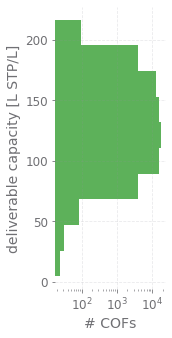

In [14]:
plt.figure(figsize=(2.5, 4.8))
plt.hist(y, orientation="horizontal", color=cool_colors[7])
plt.xlabel("# COFs")
plt.ylabel("deliverable capacity [L STP/L]")
plt.xscale("log")
plt.tight_layout()
plt.savefig("y_distn.pdf", format="pdf")

### max rank among acquired set

In [15]:
y_max_mu_BO, y_max_sig_bot_BO, y_max_sig_top_BO = y_max(bo_res, rank=True)
y_max_mu_es, y_max_sig_bot_es, y_max_sig_top_es = y_max(es_res, rank=True)
y_max_mu_rs, y_max_sig_bot_rs, y_max_sig_top_rs = y_max(rs_res, rank=True)

y_max_mu_rf,     y_max_sig_bot_rf,     y_max_sig_top_rf     = y_max_rf(rf_res, rank=True)
y_max_mu_rf_div, y_max_sig_bot_rf_div, y_max_sig_top_rf_div = y_max_rf(rf_div_res, rank=True)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


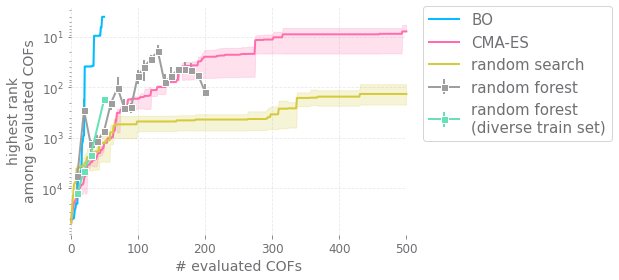

In [16]:
plt.figure()

plt.plot(np.arange(bo_res['nb_iterations'])+1, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(np.arange(bo_res['nb_iterations'])+1, y_max_mu_BO - y_max_sig_bot_BO, 
                                                       y_max_mu_BO + y_max_sig_top_BO, 
                 alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(np.arange(es_res['nb_iterations'])+1, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(np.arange(es_res['nb_iterations'])+1, y_max_mu_es - y_max_sig_bot_es, 
                                                       y_max_mu_es + y_max_sig_top_es, 
                 alpha=0.2, ec="None", color=search_to_color['evolutionary'])

plt.plot(np.arange(rs_res['nb_iterations'])+1, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(np.arange(rs_res['nb_iterations'])+1, y_max_mu_rs - y_max_sig_bot_rs, 
                                                       y_max_mu_rs + y_max_sig_top_rs, 
                 alpha=0.2, ec="None", color=search_to_color['random'])

# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest")
plt.errorbar(rf_div_res['nb_evals_budgets'], y_max_mu_rf_div, yerr=np.vstack((y_max_sig_bot_rf_div, y_max_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)")

plt.xlabel('# evaluated COFs')
plt.ylabel('highest rank\namong evaluated COFs')
plt.xlim([0, 500])
# plt.ylim(ymin=1)
# plt.legend(fontsize=1/4)
# plt.axhline(y=0) # to see the band bleed into negative zone.
plt.yticks()
plt.xticks()
plt.yscale("log")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=15)
plt.savefig("search_efficiency_rank.pdf")#, bbox_inches="tight")

### fraction of top 100 COFs recovered

In [17]:
top_100_COF_ids = np.flip(np.argsort(y))[:100]
assert np.size(top_100_COF_ids) == 100
print("top 100 COFs range from y =", np.min(y[top_100_COF_ids]), "to", np.max(y[top_100_COF_ids]))

top 100 COFs range from y = 195.43880373 to 216.894110699


In [18]:
def fraction_in_top100_cofs(ids_acquired):
    nb_in_top_100 = 0
    for id_acquired in ids_acquired:
        if id_acquired in top_100_COF_ids:
            nb_in_top_100 += 1
    return nb_in_top_100 / 100

In [19]:
# get fraction of aquired COFs in top 100 for
def y_top_100(res):
    y_top100_mu      = np.zeros(res['nb_iterations'])
    y_top100_sig_bot = np.zeros(res['nb_iterations'])
    y_top100_sig_top = np.zeros(res['nb_iterations'])
    for i in range(1, res['nb_iterations']):
        # max value acquired up to this point
        y_top100s = np.array([fraction_in_top100_cofs(res['ids_acquired'][r][:i]) for r in range(res['nb_runs'])]) # among runs
        assert np.size(y_top100s) == res['nb_runs']
        y_top100_mu[i]      = np.mean(y_top100s)
        y_top100_sig_bot[i] = np.std(y_top100s[y_top100s < y_top100_mu[i]])
        y_top100_sig_top[i] = np.std(y_top100s[y_top100s > y_top100_mu[i]])
    return y_top100_mu, y_top100_sig_bot, y_top100_sig_top

y_top100_mu_BO, y_top100_sig_bot_BO, y_top100_sig_top_BO = y_top_100(bo_res)
y_top100_mu_es, y_top100_sig_bot_es, y_top100_sig_top_es = y_top_100(es_res)
y_top100_mu_rs, y_top100_sig_bot_rs, y_top100_sig_top_rs = y_top_100(rs_res)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
def y_top_100_rf(rf_res, rank=False):
    # one for each # of evaluation budgets
    y_top100_mu      = np.zeros(len(rf_res['nb_evals_budgets']))
    y_top100_sig_bot = np.zeros(len(rf_res['nb_evals_budgets']))
    y_top100_sig_top = np.zeros(len(rf_res['nb_evals_budgets']))
    for b in range(len(rf_res['nb_evals_budgets'])):
        # get y max over runs.
        y_top100s = np.array([fraction_in_top100_cofs(rf_res['ids_acquired'][b][r]) for r in range(rf_res['nb_runs'])])
        assert np.size(y_top100s) == rf_res['nb_runs']
        y_top100_mu[b]      = np.mean(y_top100s)
        y_top100_sig_bot[b] = np.std(y_top100s[y_top100s < y_top100_mu[b]])
        y_top100_sig_top[b] = np.std(y_top100s[y_top100s > y_top100_mu[b]])
    return y_top100_mu, y_top100_sig_bot, y_top100_sig_top   

y_top100_mu_rf,    y_top100_sig_bot_rf,     y_top100_sig_top_rf     = y_top_100_rf(rf_res)
y_top100_mu_rf_div, y_top100_sig_bot_rf_div, y_top100_sig_top_rf_div = y_top_100_rf(rf_div_res)

/home/cokes/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


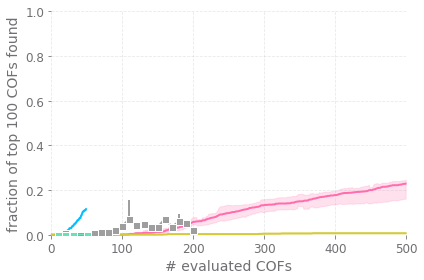

In [21]:
plt.figure()
plt.ylabel('fraction of top 100 COFs found')
plt.xlabel('# evaluated COFs')

plt.plot(np.arange(1, bo_res['nb_iterations']), y_top100_mu_BO[1:], label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(np.arange(1, bo_res['nb_iterations']), y_top100_mu_BO[1:] - y_top100_sig_bot_BO[1:], 
                                                        y_top100_mu_BO[1:] + y_top100_sig_top_BO[1:], 
                 alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(np.arange(1, es_res['nb_iterations']), y_top100_mu_es[1:], label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(np.arange(1, es_res['nb_iterations']), y_top100_mu_es[1:] - y_top100_sig_bot_es[1:], 
                                                        y_top100_mu_es[1:] + y_top100_sig_top_es[1:], 
                 alpha=0.2, ec="None", color=search_to_color['evolutionary'])

plt.plot(np.arange(1, rs_res['nb_iterations']), y_top100_mu_rs[1:], label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(np.arange(1, rs_res['nb_iterations']), y_top100_mu_rs[1:] - y_top100_sig_bot_rs[1:], 
                                                        y_top100_mu_rs[1:] + y_top100_sig_top_rs[1:], 
                 alpha=0.2, ec="None", color=search_to_color['random'])

# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_top100_mu_rf,     yerr=np.vstack((y_top100_sig_bot_rf,     y_top100_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest")
plt.errorbar(rf_div_res['nb_evals_budgets'], y_top100_mu_rf_div, yerr=np.vstack((y_top100_sig_bot_rf_div, y_top100_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)")

plt.xlim([0, 500])
plt.ylim([0, 1])
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.savefig("search_efficiency_top100.pdf", format="pdf")